# [Computational Social Science] Project 4: Unsupervised Learning

**Enter your Name:**__Cindy Alvarez_____

*Semester:* Fall 2024

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [1]:
!pip install tensorflow
!pip install keras

# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split


In [2]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


In [3]:
# View target column 

nhanes_scaled['HSD010'].unique()

array([1, 2, 3, 4, 5])

## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

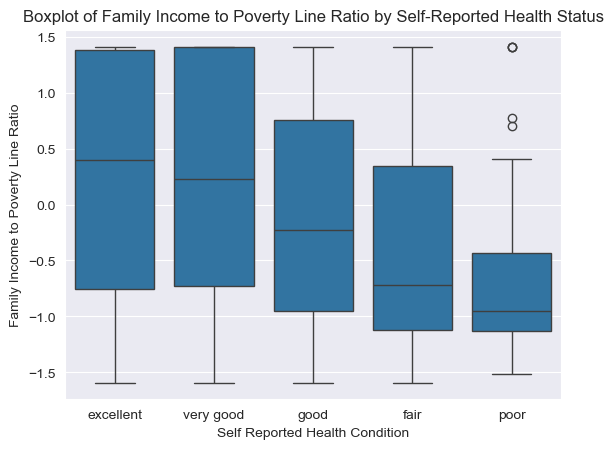

In [4]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

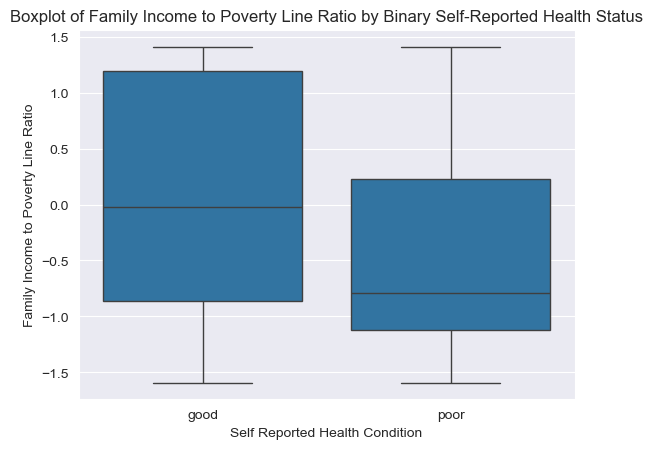

In [5]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

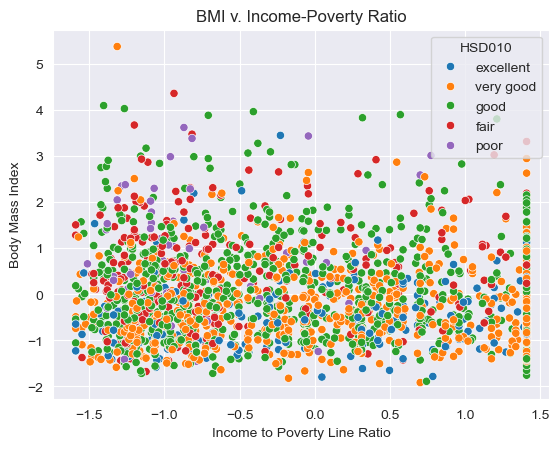

In [6]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [7]:
# saving outcome variable of interest (binary)
target = nhanes_scaled['HSD010_binary'].copy()  
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

In [8]:
print(target.value_counts())

HSD010_binary
good    1732
poor     332
Name: count, dtype: int64


## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

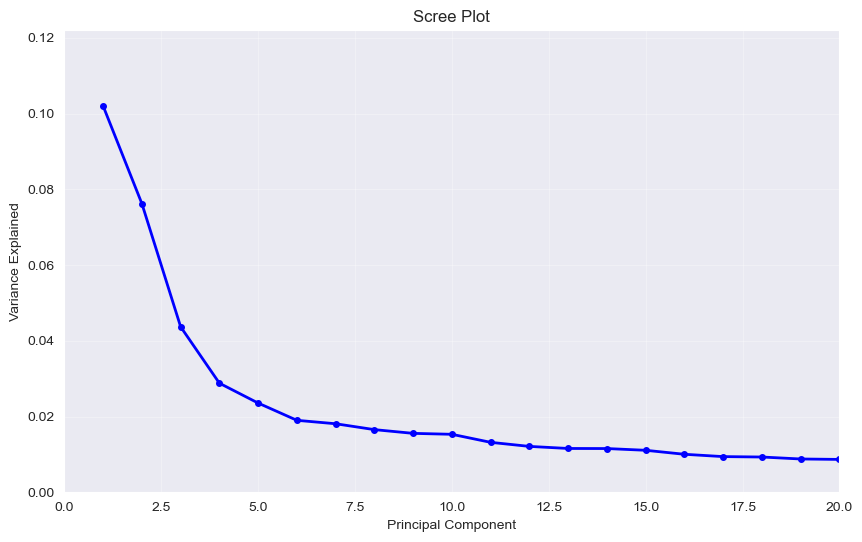

In [9]:
# Fit PCA
pca_all = PCA()
principalComponents_nhanes_scaled = pca_all.fit_transform(nhanes_scaled)

# Create enhanced scree plot
PC_values = np.arange(pca_all.n_components_) + 1
plt.figure(figsize=(10, 6))  # Just making the plot a bit bigger
plt.plot(PC_values, pca_all.explained_variance_ratio_, 'bo-', linewidth=2, markersize=4)
plt.grid(True, alpha=0.3)  # Add subtle grid
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.xlim(0, 20)  # Zoom to first 20 components
plt.ylim(0, max(pca_all.explained_variance_ratio_) + 0.02)  # Add small padding above max value
plt.show()

Given the above scree plot, the biggest drop off where we see diminishing returns ("the elbow") in the scree plot seems to be between 4-5 components. There is a clear elbow at this point after which teh variance explained drops off more gradually. 

### Barplot of Components

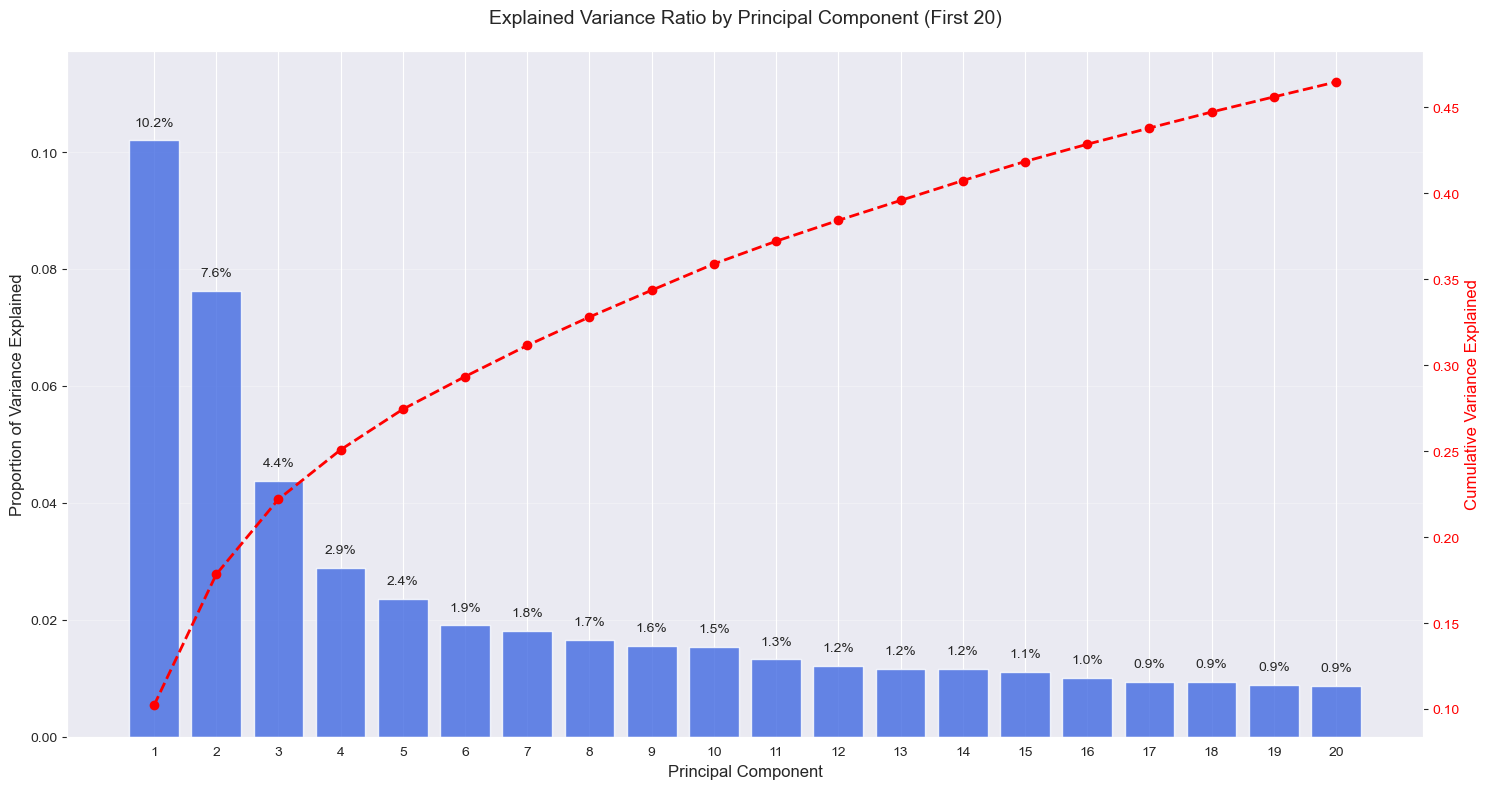

In [10]:
# Get the first 20 components
n_components = 20
explained_variance = pca_all.explained_variance_ratio_[:n_components]

# Create bar plot with improved readability
plt.figure(figsize=(15, 8))
bars = plt.bar(range(1, n_components + 1), explained_variance, alpha=0.8, color='royalblue')
plt.xlabel('Principal Component', fontsize=12)
plt.ylabel('Proportion of Variance Explained', fontsize=12)
plt.title('Explained Variance Ratio by Principal Component (First 20)', fontsize=14, pad=20)

# Add grid for better readability
plt.grid(True, axis='y', alpha=0.3)

# Add percentage labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.002,
             f'{height:.1%}',
             ha='center', va='bottom', fontsize=10)

# Customize the plot
plt.xticks(range(1, n_components + 1))
plt.ylim(0, max(explained_variance) * 1.15)

# Add cumulative variance line
cumulative_variance = np.cumsum(explained_variance)
ax2 = plt.twinx()
ax2.plot(range(1, n_components + 1), cumulative_variance, color='red', marker='o', linestyle='--', linewidth=2, markersize=6)
ax2.set_ylabel('Cumulative Variance Explained', fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.grid(False)

plt.tight_layout()
plt.show()

### How many components will you use to fit a supervised learning model?

Given the above bar chart, I will use 5 components to fit a supervised learning model. After 5 components, the subsequent component only capures 1.9% of additional variance. As computational efficiency is a priority for me, I will use 5 components.

### 2D Scatterplot of the first two components

In [11]:
## Your Answer Here

# apply PCA
# ----------
pca_2 = PCA(n_components=2)
principalComponents_nhanes_2 = pca_2.fit_transform(nhanes_scaled)

# convert into a dataframe
# ----------
pca_df = pd.DataFrame(data = principalComponents_nhanes_2, 
                      columns = ['principal component 1',
                                 'principal component 2'])

# view factor loadings as dataframe
pca_df.head()

,principal component 1,principal component 2
0,9.527811,-0.816226
1,-5.838338,-3.692575
2,-0.719454,-2.573202
3,3.533627,-2.576982
4,-6.872095,-4.194242


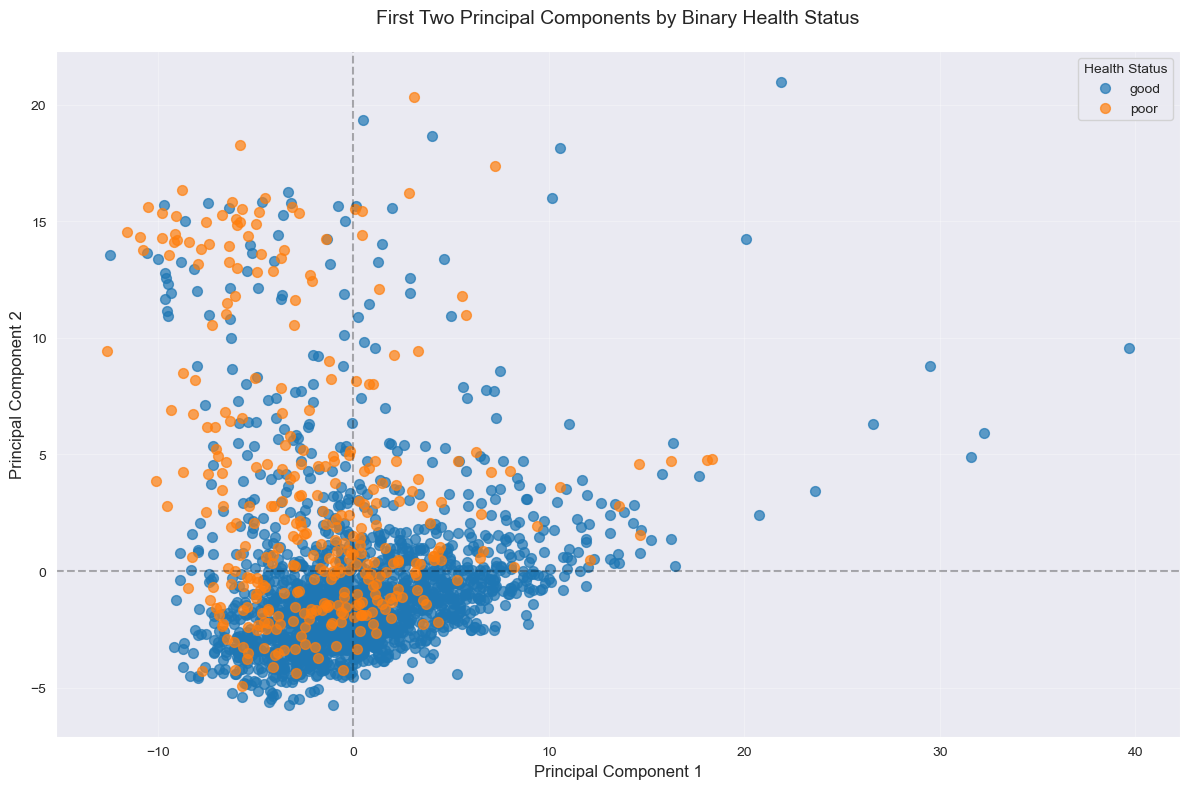

In [12]:
plt.figure(figsize=(12, 8))

# Plot points for each health status
for status in target.unique():
    # Create boolean mask and ensure index alignment
    mask = (target == status).values  # Convert to numpy array to avoid index issues
    plt.scatter(pca_df.iloc[mask]['principal component 1'],
               pca_df.iloc[mask]['principal component 2'],
               alpha=0.7,
               s=50,
               label=status)

# Add labels and title
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.title('First Two Principal Components by Binary Health Status', fontsize=14, pad=20)

# Add grid and legend
plt.grid(True, alpha=0.3)
plt.legend(title='Health Status', fontsize=10)

# Add axis lines
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

The pattern suggests that while there is some distinction between good and poor health status in these 2 principal components, there isn't a clear, complete separation between the groups. This indicates that the relationship between the variables and health status is complex.

In [13]:
# Fitting a PCA model with 5 componnets for my supervised learning and the next section of the assignment

# New PCA with 5 components for supervised learning
pca_5 = PCA(n_components=5)
principalComponents_nhanes_5 = pca_5.fit_transform(nhanes_scaled)
pca_df_5 = pd.DataFrame(data=principalComponents_nhanes_5,
                       columns=['principal component 1', 
                               'principal component 2',
                               'principal component 3',
                               'principal component 4',
                               'principal component 5'])


## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

I am choosing K-means clustering. K-means clustering is an algorithm that groups similar data points together by iteratively finding k cluster centers (centroids) and assigning each point to its nearest center, then updating the centers based on the mean position of all points in each cluster. The process continues until the cluster centers stabilize, resulting in k distinct groups of data points that are as close as possible to their assigned centroids.

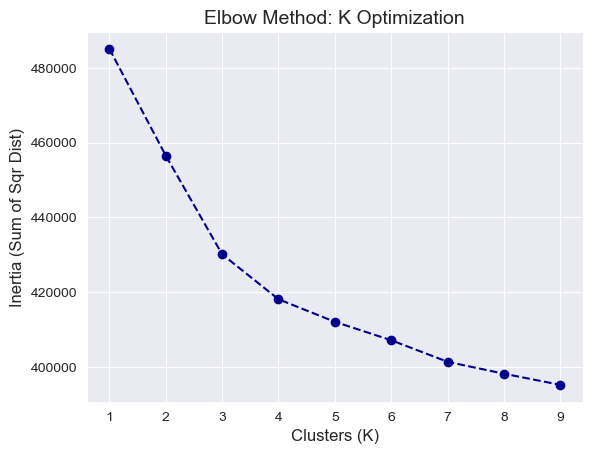

In [14]:
#Inertia Object
inertia = []

k_range = range(1, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(nhanes_scaled)
    inertia.append(kmeans.inertia_)

# Plot
plt.plot(k_range, inertia, marker='o', color='darkblue', linestyle='--')
plt.title('Elbow Method: K Optimization', fontsize=14)
plt.xlabel('Clusters (K)', fontsize=12); plt.ylabel('Inertia (Sum of Sqr Dist)', fontsize=12)
plt.grid(True); plt.show()


I used the elbow method to determine the number of clusters. Given that the elbow appears to take place at 4 clusters, I will use 4 below.

### Cluster nhanes

In [15]:
np.random.seed(10)
# Initialize KMeans
kmeans = KMeans(n_clusters=4,
                n_init=10,
                max_iter=300 #default
                ).fit(nhanes_scaled)

In [16]:
# Fitting the KMeans model on the dataset, leaving out the outcome variable
nhanes_scaled['Cluster'] = kmeans.labels_

# Generating a DataFrame for the cluster centers
cluster_centers_df = pd.DataFrame(data=kmeans.cluster_centers_, 
                                  columns=nhanes_scaled.columns[:-1])

# Displaying the calculated cluster centers
print("Cluster Centers:")
print(cluster_centers_df)

Cluster Centers:
   DR1DRSTZ  DR1EXMER  DRABF    DRDINT   DR1DBIH    DR1DAY   DR1LANG  \
0       0.0 -0.001403    0.0  0.027785  0.176059 -0.025422 -0.011846   
1       0.0  0.031854    0.0  0.063039 -0.034526  0.046707 -0.085075   
2       0.0 -0.025545    0.0 -0.126271 -0.066961  0.011318  0.069053   
3       0.0 -0.049580    0.0  0.139197  0.019053 -0.216630  0.166909   

   DR1MNRSP  DR1HELPD   DBQ095Z  ...    OHQ033    OHQ770    OHQ845   PAAQUEX  \
0  0.012097  0.001522 -0.033369  ... -0.104709  0.107980 -0.121219 -0.045515   
1 -0.057306  0.057865 -0.064511  ... -0.220143  0.215904 -0.228040 -0.148007   
2  0.041747 -0.067232  0.108991  ...  0.055156 -0.184123  0.182986  0.323067   
3  0.083251 -0.014251 -0.047209  ...  1.120207 -0.576401  0.673493 -0.484200   

     SMQ860  SMQ870    SMQ872    SMQ874    SMQ878  SMAQUEX.x  
0 -0.110446     0.0 -0.017969  0.006048 -0.040921   0.002135  
1 -0.333157     0.0  0.233251 -0.076885 -0.182694   0.165583  
2  0.398346     0.0 -0.198804  0

In [17]:
# Displaying the count of data points in each cluster
print("\nDistribution of Data Points in Clusters:")
print(nhanes_scaled['Cluster'].value_counts())


Distribution of Data Points in Clusters:
Cluster
1    819
2    679
0    401
3    165
Name: count, dtype: int64


### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

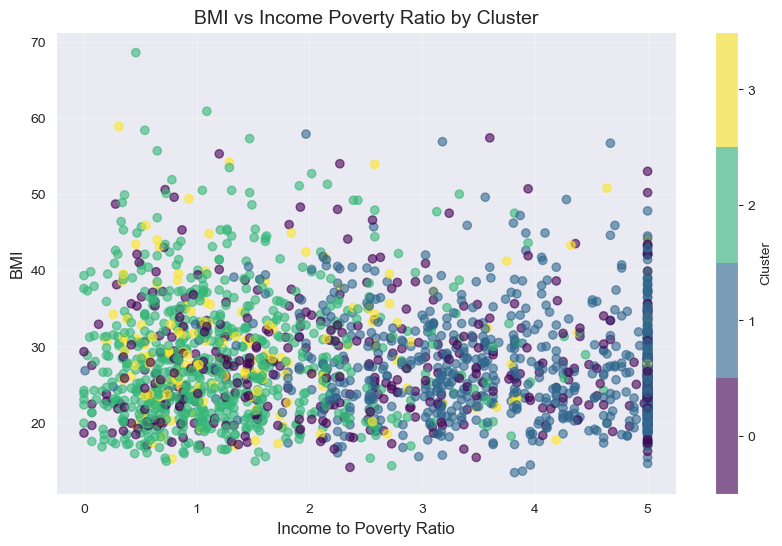

In [18]:
from matplotlib.colors import ListedColormap

plt.figure(figsize=(10, 6))

# Create a discrete colormap
n_clusters = 4
colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))  # Get n_clusters distinct colors
discrete_cmap = ListedColormap(colors)

scatter = plt.scatter(nhanes['INDFMPIR'], 
                     nhanes['BMXBMI'],
                     c=nhanes_scaled['Cluster'],  
                     cmap=discrete_cmap,    # Use our discrete colormap       
                     alpha=0.6)                   

plt.title('BMI vs Income Poverty Ratio by Cluster', fontsize=14)
plt.xlabel('Income to Poverty Ratio', fontsize=12)
plt.ylabel('BMI', fontsize=12)

# Discrete colorbar
colorbar = plt.colorbar(scatter, 
                       label='Cluster',
                       ticks=[0.375, 1.125, 1.875, 2.625])  # Center the ticks
colorbar.set_ticklabels(['0', '1', '2', '3'])  # Set the labels

plt.grid(True, alpha=0.3)
plt.show()

## Your Answer Here

In the above chart, each point represents a person and the different colors represent the 4 different clusters. The purple/blue clusters (0 and 1) seem to represent higher-income individuals (income-to-poverty ratio > 3) with moderate BMI ranges, while the green and yellow clusters (2 and 3) capture people with lower income-to-poverty ratios who have more variable BMI values, particularly showing higher BMI readings. This clustering suggests there may be socioeconomic patterns in health outcomes, where higher income groups tend to have more consistent BMI ranges while lower income groups show more BMI variability. 

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

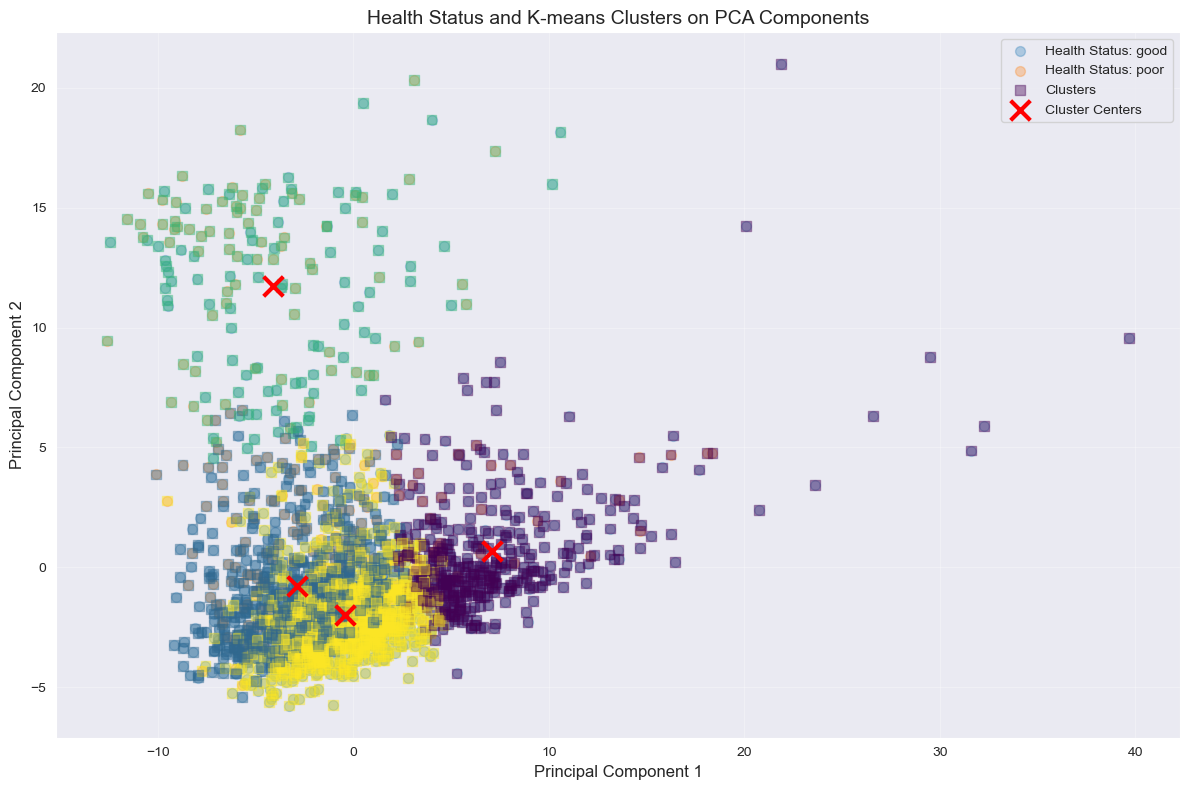

In [19]:
# Retrain K-means on PCA components using same parameters as before
np.random.seed(10)
kmeans_pca = KMeans(n_clusters=4,
                    n_init=10,
                    max_iter=300
                    ).fit(principalComponents_nhanes_5) # using all 5 components for clustering

# Create visualization
plt.figure(figsize=(12, 8))

# First plot: Original health status scatter
for status in target.unique():
    mask = (target == status).values
    plt.scatter(pca_df_5.iloc[mask]['principal component 1'], #use pca_df_5 but only plot the first 2 components
               pca_df_5.iloc[mask]['principal component 2'],
               alpha=0.3,
               s=50,
               label=f'Health Status: {status}')

# Second plot: New cluster assignments
n_clusters = 4
colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))
discrete_cmap = ListedColormap(colors)

scatter_clusters = plt.scatter(
    pca_df_5['principal component 1'], #using pca_df_5 but only plotting the first 2 components
    pca_df_5['principal component 2'],
    c=kmeans_pca.labels_,
    cmap=discrete_cmap,
    alpha=0.4,
    s=50,
    marker='s',
    label='Clusters'
)

# Add cluster centers
centers = kmeans_pca.cluster_centers_
plt.scatter(
    centers[:, 0], # plotting only the first two components of the centers
    centers[:, 1],
    c='red',
    marker='x',
    s=200,
    linewidth=3,
    label='Cluster Centers'
)

plt.title('Health Status and K-means Clusters on PCA Components', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## Your Answer Here

The K-means clustering on 5 PCA components shows four distinct clusters that show some alignment with health status outcomes, particularly along Principal Component 1. The clusters appear to capture different health profiles in the data, with some clusters showing a higher concentration of poor health status points while others contain more good health status points.

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [20]:
#  partition data
# -----------
# Convert target to numeric first ( 'good' = 1, 'poor' = 0)
y = (target == 'good').astype('int')
X = nhanes_scaled.drop(['Cluster'], axis=1)  # drop cluster column, use scaled features

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.25, 
                                                    random_state=10)

In [21]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

# convert class vectors to binary class matrices
num_classes = 2  # binary classification
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [22]:
# create neural network model
# -----------
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(16, kernel_initializer='normal', activation='relu'))
model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))

# compile and fit
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=50,
                    batch_size=32,
                    verbose=1)

# Print final accuracy
_, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('\nTest accuracy:', accuracy)


Epoch 1/50


/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7255 - loss: 0.6528 - val_accuracy: 0.8488 - val_loss: 0.4103
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8369 - loss: 0.3751 - val_accuracy: 0.8488 - val_loss: 0.3579
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8450 - loss: 0.3324 - val_accuracy: 0.8663 - val_loss: 0.3419
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8822 - loss: 0.2856 - val_accuracy: 0.8643 - val_loss: 0.3314
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8959 - loss: 0.2433 - val_accuracy: 0.8682 - val_loss: 0.3289
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9210 - loss: 0.2161 - val_accuracy: 0.8818 - val_loss: 0.3449
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9325 - loss: 0.1760 - val_accuracy: 0.8702 - val_loss: 0.3558
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9341 - loss: 0.1623 - val_accuracy: 0.8740 - val_loss: 0.3815
Epo

### Neural Network on Principal Components

In [23]:
# Using 5 PCA components
X = pd.DataFrame(principalComponents_nhanes_5, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])

# Convert target to numeric first ('good' = 1, 'poor' = 0)
y = (target == 'good').astype('int')

# Split data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=10)
# load libraries
# -----------
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

# Convert to categorical
num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Create neural network model
model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))  # now using 5 input features
model.add(Dense(8, kernel_initializer='normal', activation='relu'))
model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))

# Compile and fit
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history = model.fit(X_train, y_train,
                   validation_data=(X_test, y_test),
                   epochs=50,
                   batch_size=32,
                   verbose=1)

# Print final accuracy
_, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('\nTest accuracy:', accuracy)

Epoch 1/50


/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7603 - loss: 0.6820 - val_accuracy: 0.8488 - val_loss: 0.6204
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8300 - loss: 0.5797 - val_accuracy: 0.8488 - val_loss: 0.4192
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8389 - loss: 0.4017 - val_accuracy: 0.8488 - val_loss: 0.3727
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8420 - loss: 0.3721 - val_accuracy: 0.8488 - val_loss: 0.3701
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8301 - loss: 0.3845 - val_accuracy: 0.8488 - val_loss: 0.3689
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8477 - loss: 0.3812 - val_accuracy: 0.8566 - val_loss: 0.3672
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8317 - loss: 0.3936 - val_accuracy: 0.8624 - val_loss: 0.3653
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8464 - loss: 0.3765 - val_accuracy: 0.8740 - val_loss: 0.3634
Epo

### Neural Network on Principal Components + Cluster Membership

In [24]:
# Combine PCA components with cluster membership
X_combined = pd.DataFrame(principalComponents_nhanes_5, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
X_combined['Cluster'] = kmeans_pca.labels_  # Add cluster labels as a feature

# Convert target and prepare train/test split
y = (target == 'good').astype('int')
X_train, X_test, y_train, y_test = train_test_split(X_combined,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=10)

# Convert to categorical
num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Create neural network model
model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))  # now 6 input features (5 PCs + cluster)
model.add(Dense(8, kernel_initializer='normal', activation='relu'))
model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))

# Compile and fit
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

history = model.fit(X_train, y_train,
                   validation_data=(X_test, y_test),
                   epochs=50,
                   batch_size=32,
                   verbose=1)

# Print final accuracy
_, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('\nTest accuracy:', accuracy)


Epoch 1/50


/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8345 - loss: 0.6671 - val_accuracy: 0.8488 - val_loss: 0.5361
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8374 - loss: 0.4708 - val_accuracy: 0.8488 - val_loss: 0.3782
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8374 - loss: 0.3798 - val_accuracy: 0.8488 - val_loss: 0.3753
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8344 - loss: 0.3679 - val_accuracy: 0.8488 - val_loss: 0.3739
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8257 - loss: 0.3873 - val_accuracy: 0.8488 - val_loss: 0.3741
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8502 - loss: 0.3416 - val_accuracy: 0.8488 - val_loss: 0.3732
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8335 - loss: 0.3811 - val_accuracy: 0.8488 - val_loss: 0.3722
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8205 - loss: 0.3920 - val_accuracy: 0.8488 - val_loss: 0.3722
Epo

Based on the accuracy test results: 
Neural Network with Original Features: 85.85% accuracy
Neural Network with PCA Components: 87.02% accuracy
Neural Network with PCA + Clusters: 86.05% accuracy

I would choose the neural network with PCA components approach because it achieved the highest accuracy (87.02%), which is better than the original features neural network and the PCA + cluster approach by about 1-1.2 percentage points. While the other approaches did achieve decent accuracy, the neural network just using the PCA components probably performed the best becuase the PCA components capture the most important patterns in teh data while helping reduce noise. It also transformed the original features into uncorrelated components that might better represent the underlying patterns related to health status. Finally, the third model which added clust membership seemed to decrease performance slightly. This suggests that the clustering information may be redundant with the PCA components captured in the seocnd neural network.

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

PCA focuses on dimensionality reduction by creating new features (components) that capture the most variance in the data while maintaining linear relationships between variables. It transforms the original features into a new coordinate system. Clustering, on the other hand, focuses on finding natural groupings within the data by identifying patterns of similarity between observations. It segments the data into distinct groups based on how close or similar points are to each other.

## Your Answer Here

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

I didn't see substantial gains from combining PCA and clustering (accuracy actually decreased). This suggests that the cluster memberships didn't add much new predictive information and were poenttially redundant with what the PCA components had already captured. 

## Your Answer Here

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

Dimensionality reduction (like PCA) can make large datasets more manageable by reducing computational complexity while preserving important patterns. These techniques can help reduce noise and redundancy in the data, potentially improving model performance. 